In [2]:
# This notebooks tests effect of parameter \mu on PSPS2-L1 and PSPS2-L2 methods

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import optuna 

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from torch.optim import SGD, Adam

import matplotlib.pyplot as plt
# plt.rcParams['figure.facecolor'] = 'white'

from datasets import get_dataset
from loss_fns import get_loss
from utils import solve

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def logistic_reg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def nllsq(w, X, y):
    return torch.mean( ( y - (1/(1 + torch.exp(-X @ w ))) )**2 )

def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

In [7]:
# Setup
batch_size = 64
dataset_name = "mushrooms"
percentage = 1.0

# training 
STEPS = 150
loss_name = "logreg"
loss_class = get_loss(loss_name)

torch.random.manual_seed(0)

scale_k = 0
scale_range = [-scale_k, scale_k] # [-value, value]
train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_range, loss_class.y_range)
train_data = train_data.to(torch.get_default_dtype())
train_target = train_target.to(torch.get_default_dtype())
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)


/home/farshed.abdukhakimov/projects/sps2/datasets


In [8]:
def run_pspsl1(mu):
    # parameters
    alpha = 1e-4
    beta=0.999
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    s = torch.tensor(0.0)
    lmd = 0.01

    loss_function = loss_class(w)

    # save loss and grad size to history
    hist_sps_l1 = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_sps_l1.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])

    # preconditioninig matrix
    Dk = diag_estimate_old(w, g, 100)

    for step in range(STEPS):

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)

            s_nil = s - (lmd/(2*mu))
            z = s - s_nil
            
            if (i != 0) and s_nil >= loss.item():
                continue

            g, = torch.autograd.grad(loss, w, create_graph=True)

            vk = diag_estimate_old(w, g, 1)

            # Smoothing and Truncation 
            Dk = beta * Dk + (1 - beta) * vk
            Dk_hat = torch.abs(Dk)
            Dk_hat[Dk_hat < alpha] = alpha

            Dk_hat_inv = 1 / Dk_hat

            gnorm = (g * Dk_hat_inv).dot(g)

            f_grad = g.clone().detach()

            if gnorm < 1e-8:
                continue

            t = loss.item() - s_nil
            a = torch.dot(f_grad, Dk_hat_inv*f_grad).cpu().detach().numpy()
            
            AA = 1
            BB = 2 + mu * a - 2 * mu * t
            CC = 1 + 2 * mu * a - 4 * mu * t
            DD = -2 * mu * t

            roots = solve(AA, BB, CC, DD)
            roots = torch.from_numpy(roots)      
            root_star = torch.relu(torch.max(roots))

            s = torch.relu(s - ((lmd - root_star)/2 * mu)).item()
        
            precond = root_star/(1 + root_star) * Dk_hat_inv    
            with torch.no_grad():
                w.sub_(precond  * f_grad)

        loss = loss_function(train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | s: {s} | s_nil + z = {s_nil + z}")
        hist_sps_l1.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])    


    return hist_sps_l1        

In [9]:
def run_pspsl2(mu):
    # parameters
    alpha = 1e-4
    beta=0.999
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    s = torch.tensor(0.0)
    lmd = 0.01
    delta = lmd + mu

    loss_function = loss_class(w)

    # save loss and grad size to history
    hist_sps_l2 = []
    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_sps_l2.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])

    # preconditioninig matrix
    Dk = diag_estimate_old(w, g, 100)

    for step in range(STEPS):

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(batch_data, batch_target)

            s_nil = s - (lmd/(2*mu))
            z = s - s_nil
            
            if (i != 0) and s_nil >= loss.item():
                continue

            g, = torch.autograd.grad(loss, w, create_graph=True)

            vk = diag_estimate_old(w, g, 1)

            # Smoothing and Truncation 
            Dk = beta * Dk + (1 - beta) * vk
            Dk_hat = torch.abs(Dk)
            Dk_hat[Dk_hat < alpha] = alpha

            Dk_hat_inv = 1 / Dk_hat

            gnorm = (g * Dk_hat_inv).dot(g)

            f_grad = g.clone().detach()

            if gnorm < 1e-8:
                continue

            t = loss.item() - s_nil
            a = torch.dot(f_grad, Dk_hat_inv*f_grad).cpu().detach().numpy()
            
            AA = 1
            BB = 2 + delta * a - 2 * delta * t
            CC = 1 + 2 * delta * a - 4 * delta * t
            DD = -2 * delta * t

            roots = solve(AA, BB, CC, DD)
            roots = torch.from_numpy(roots)      
            root_star = torch.relu(torch.max(roots))

            s = (1/delta) * (mu * s + (root_star/2)).item()
            
            precond = root_star/(1 + root_star) * Dk_hat_inv    
            with torch.no_grad():
                w.sub_(precond  * f_grad)

        loss = loss_function(train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | s: {s} | s_nil + z = {s_nil + z}")
        hist_sps_l2.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])


    return hist_sps_l2

In [14]:
l1 = []
l2 = []
for i in range(-15, 6):
    mu = np.exp(i)
    print(mu)
    hist_l1 = run_pspsl1(mu)
    hist_l2 = run_pspsl2(mu)
    l1.append(hist_l1)
    l2.append(hist_l2)

3.059023205018258e-07
Loss: 0.6931471805599454 | GradNorm^2: 0.3195669607542957
Loss: 0.08157946265983726 | GradNorm^2: 0.002529387973680531 | s: 2.0744271097515555e-12 | s_nil + z = 1.8189894035458565e-12
Loss: 0.04562322530582469 | GradNorm^2: 0.0007494176479378146 | s: 2.7820686533469397e-12 | s_nil + z = 3.637978807091713e-12
Loss: 0.031452250021016204 | GradNorm^2: 0.0003297575315529 | s: 3.2269072928884775e-12 | s_nil + z = 3.637978807091713e-12
Loss: 0.023732516443060063 | GradNorm^2: 0.0001771801286138494 | s: 3.5486625608448906e-12 | s_nil + z = 3.637978807091713e-12
Loss: 0.018830380320303732 | GradNorm^2: 0.0001062062630045048 | s: 3.79797005488802e-12 | s_nil + z = 3.637978807091713e-12
Loss: 0.015436150532076094 | GradNorm^2: 6.703566150372059e-05 | s: 3.9990245712494e-12 | s_nil + z = 3.637978807091713e-12
Loss: 0.012934918010576155 | GradNorm^2: 4.4177468127147425e-05 | s: 4.1657528873645085e-12 | s_nil + z = 3.637978807091713e-12
Loss: 0.01101477711861351 | GradNorm^2: 

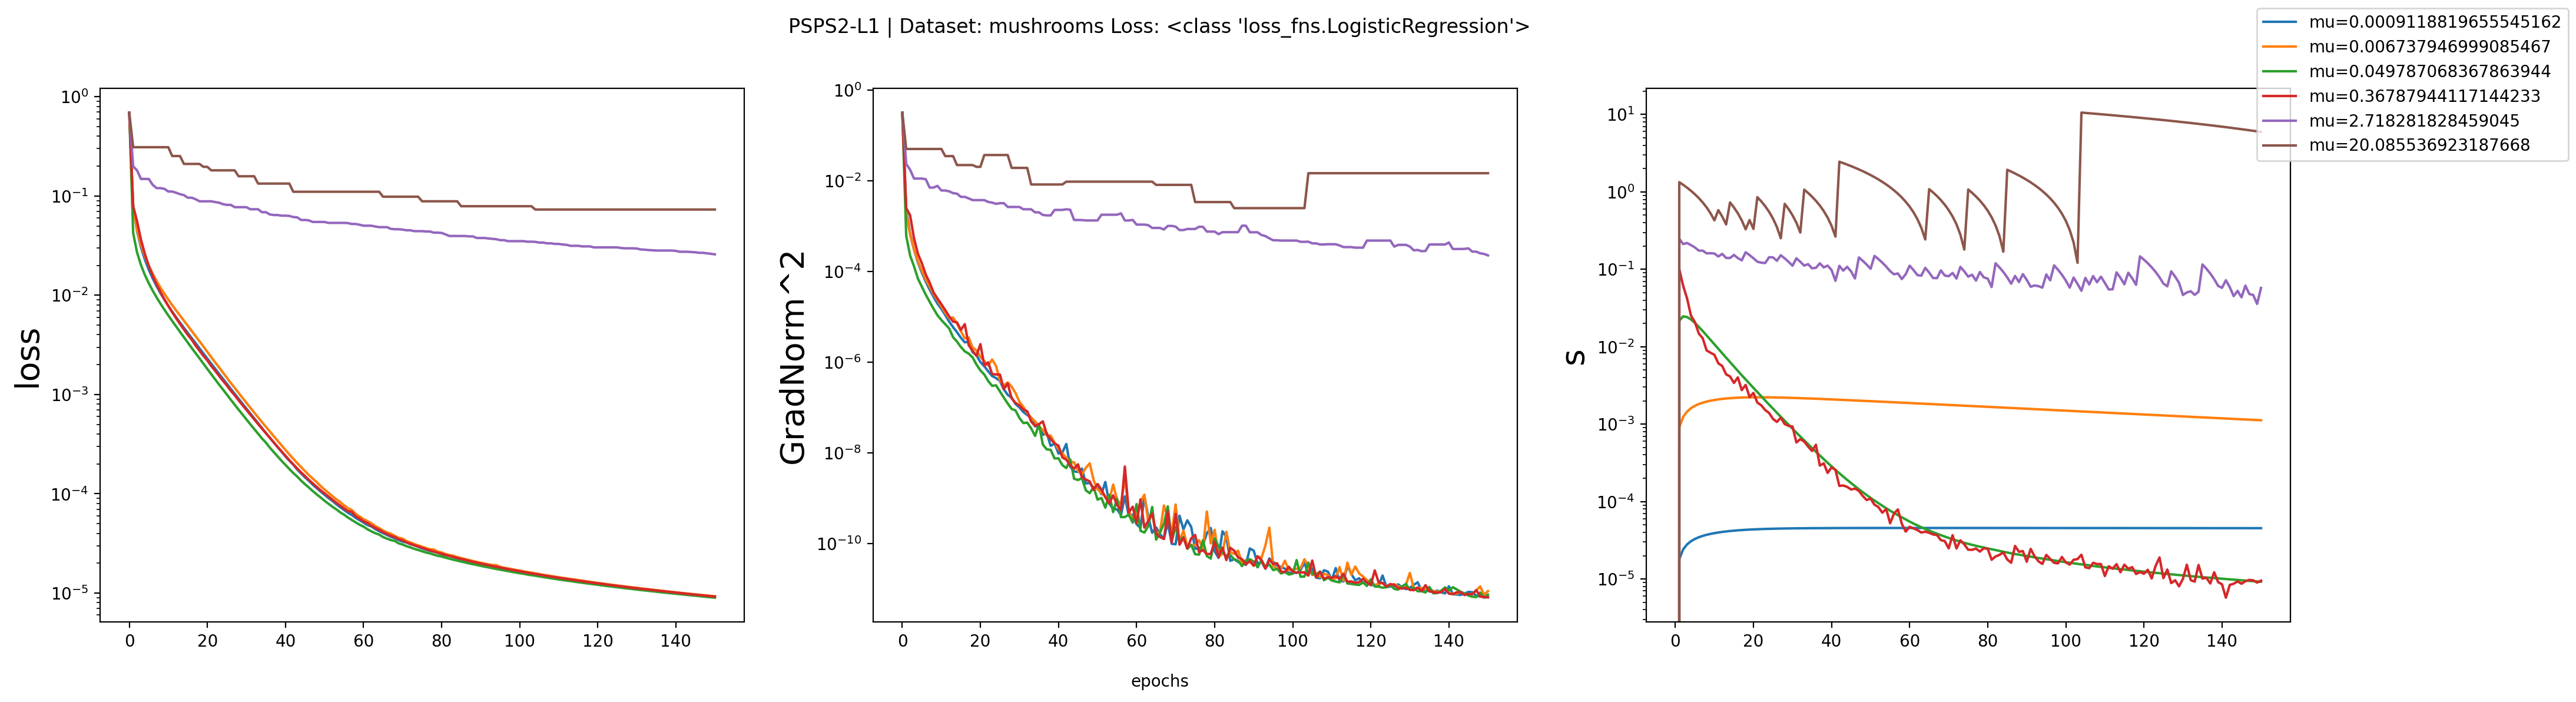

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), dpi=200)

labels = [np.exp(i) for i in range(-15, 6)]

for res, e in zip(l1[8:-1:2], labels[8:-1:2]):
    ax1.semilogy([x[0] for x in res])
    ax2.semilogy([x[1] for x in res])
    ax3.semilogy([x[2] for x in res], label=f"mu={e}")


ax1.set_ylabel('loss', fontsize=20)
ax2.set_ylabel('GradNorm^2', fontsize=20)
ax3.set_ylabel('s', fontsize=20)

fig.text(0.5, 0.04, 'epochs', ha='center', va='center', )
fig.suptitle(f"PSPS2-L1 | Dataset: {dataset_name} Loss: {loss_class}")
fig.legend()
# plt.tight_layout()
fig.show()

# fig.savefig(f"../plots/psps2_{dataset_name}_logreg_scale:{scale_range}.png")

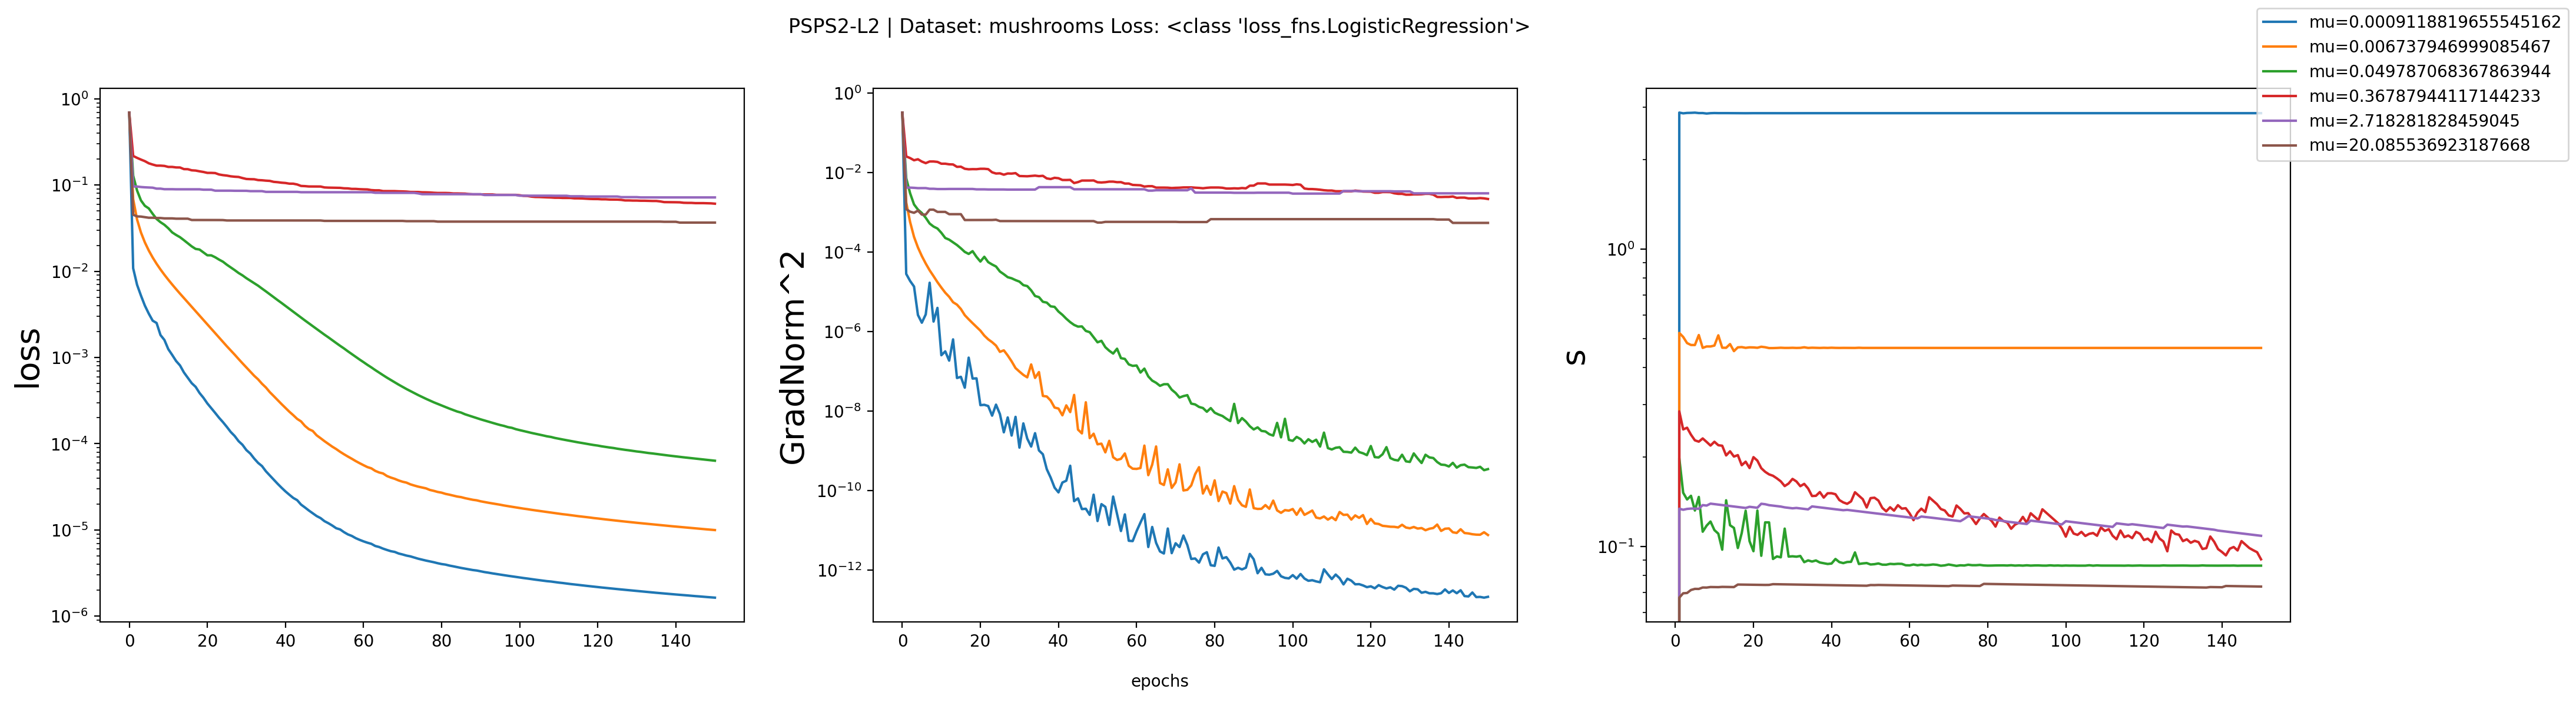

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), dpi=200)

labels = [np.exp(i) for i in range(-15, 6)]

for res, e in zip(l2[8:-1:2], labels[8:-1:2]):
    ax1.semilogy([x[0] for x in res])
    ax2.semilogy([x[1] for x in res])
    ax3.semilogy([x[2] for x in res], label=f"mu={e}")


ax1.set_ylabel('loss', fontsize=20)
ax2.set_ylabel('GradNorm^2', fontsize=20)
ax3.set_ylabel('s', fontsize=20)

fig.text(0.5, 0.04, 'epochs', ha='center', va='center', )
fig.suptitle(f"PSPS2-L2 | Dataset: {dataset_name} Loss: {loss_class}")
fig.legend()
# plt.tight_layout()
fig.show()